In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import random
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import operator

In [2]:
train = pd.read_csv('../input/train.csv',dtype={'StateHoliday':object}) 
store =  pd.read_csv('../input/store.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)  

### 整理数据

#### 整理test数据

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [5]:
#补充缺失数据
# 特征Open存在数据缺失
# print(test.query('Open=="NaN"'))
#根据Open为NaN的数据展现，由于日期非节假日商店应该都是开门的把NaN替换成1，把0.0变成0，把1.0变成1
test['Open']=test['Open'].fillna(1)
test['Open']=test['Open'].astype(int)
# print(test['Open'].value_counts())

In [6]:
# 把date拆成year，month和day，重新设置DayOfWeek原因是DayOfWeek比dayofweek多1
test['Date']=pd.to_datetime(test['Date'])

test['Year']=test['Date'].dt.year
test['Month']=test['Date'].dt.month
test['Day']=test['Date'].dt.day
test['WeekOfYear']=test['Date'].dt.weekofyear
test['DayOfWeek']=test['Date'].dt.dayofweek
test.drop('Date',axis=1, inplace=True)

In [7]:
#设置StateHoliday a:1,b:2,c:3
test.loc[test["StateHoliday"]=='a','StateHoliday']=1
test.loc[test["StateHoliday"]=='b','StateHoliday']=2
test.loc[test["StateHoliday"]=='c','StateHoliday']=3
test['StateHoliday']=test['StateHoliday'].astype(int)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 11 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Open             41088 non-null int32
Promo            41088 non-null int64
StateHoliday     41088 non-null int32
SchoolHoliday    41088 non-null int64
Year             41088 non-null int64
Month            41088 non-null int64
Day              41088 non-null int64
WeekOfYear       41088 non-null int64
dtypes: int32(2), int64(9)
memory usage: 3.1 MB


In [8]:
# 如果open特征为0可以直接提交预测为0
test["Open"].value_counts()

1    35104
0     5984
Name: Open, dtype: int64

#### 整理store数据

In [9]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [10]:
#处理缺失数据
#CompetitionDistance中缺失三条,缺失的数据里同时缺失CompetitionOpenSinceMonth和CompetitionOpenSinceYear，我将其认为在合理距离范围内无竞争对手。
print(store.query('CompetitionDistance=="NaN"')[['Store','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear']])
#可以理解为合理范围内没有任何的竞争对手记下Store号码：291，622，879

     Store  CompetitionDistance  CompetitionOpenSinceMonth  \
290    291                  nan                        nan   
621    622                  nan                        nan   
878    879                  nan                        nan   

     CompetitionOpenSinceYear  
290                       nan  
621                       nan  
878                       nan  


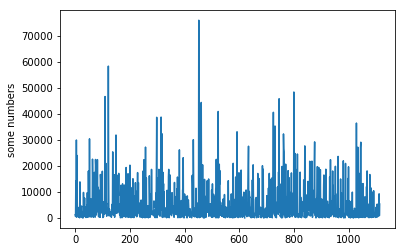

In [11]:
#查看CompetitionDistance的情况
store['CompetitionDistance'].describe()
#根据情况将291，622，879的CompetitionDistance距离改为99999
plt.plot(store['CompetitionDistance'])
plt.ylabel('some numbers')
plt.show()


In [12]:
#根据情况将291，622，879的CompetitionDistance距离改为99999并转化为int型，将其CompetitionOpenSinceYear特征改为一个未来值
store['CompetitionDistance']=store['CompetitionDistance'].fillna(99999)
store['CompetitionDistance']=store['CompetitionDistance'].astype(int)
# store.query('Store in (291,622,879)')['CompetitionOpenSinceYear']=2030
store.loc[(store['Store']==291)|(store['Store']==622)|(store['Store']==879),'CompetitionOpenSinceYear']=2030

In [13]:
# CompetitionOpenSinceMonth和CompetitionOpenSinceYear的缺失值
# 判断是否缺失的商店是同一个，输出同时为NaN的商店个数
print(len(store.query('CompetitionOpenSinceMonth=="NaN"&CompetitionOpenSinceYear=="NaN"')))

351


In [14]:
# 1115-354=761所以均为同时为Nan，那就设置为一个较早的时间，认为是早已经开业的商店,并设置为int型
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].fillna(2010)
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].fillna(0)
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].astype(int)
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].astype(int)

In [15]:
# Promo2SinceWeek,Promo2SinceYear,PromoInterval的缺失值
# 确认他们缺失的是否是相同的store
nan = np.nan
print(len(store.query('Promo2SinceWeek=="NaN"&Promo2SinceYear=="NaN"&PromoInterval.isnull()')))

544


In [16]:
# 1115-544=571,571符合这三个特征的缺失数，得出结论就是这三个特征是同时缺失的，看看此时的Promo2的值是多少
store.query('Promo2SinceWeek=="NaN"&Promo2SinceYear=="NaN"&PromoInterval.isnull()')['Promo2'].value_counts()

0    544
Name: Promo2, dtype: int64

In [17]:
# 查看0的总总数量和Promo2SinceWeek,Promo2SinceYear,PromoInterval缺失值保持一致
store['Promo2'].value_counts()

1    571
0    544
Name: Promo2, dtype: int64

In [18]:
# 将Promo2SinceYear设置为一个未来的时间，Promo2SinceWeek设置为1
store['Promo2SinceWeek']=store['Promo2SinceWeek'].fillna(0)
store['Promo2SinceYear']=store['Promo2SinceYear'].fillna(2030)
store['Promo2SinceWeek']=store['Promo2SinceWeek'].astype(int)
store['Promo2SinceYear']=store['Promo2SinceYear'].astype(int)

In [19]:
#处理PromoInterval,
print(store['PromoInterval'].value_counts())
num_month = {'Jan,Apr,Jul,Oct':'0,3,6,9','Feb,May,Aug,Nov':'1,4,7,10','Mar,Jun,Sept,Dec':'2,5,8,11'}
store['PromoInterval'] =store['PromoInterval'].map(num_month)
store['PromoInterval']=store['PromoInterval'].fillna('0,0,0,0')
store.head()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9,2008,0,0,2030,"0,0,0,0"
1,2,a,a,570,11,2007,1,13,2010,"0,3,6,9"
2,3,a,a,14130,12,2006,1,14,2011,"0,3,6,9"
3,4,c,c,620,9,2009,0,0,2030,"0,0,0,0"
4,5,a,a,29910,4,2015,0,0,2030,"0,0,0,0"


In [20]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1115 non-null int32
CompetitionOpenSinceMonth    1115 non-null int32
CompetitionOpenSinceYear     1115 non-null int32
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null int32
Promo2SinceYear              1115 non-null int32
PromoInterval                1115 non-null object
dtypes: int32(5), int64(2), object(3)
memory usage: 65.4+ KB


In [21]:
print(store['PromoInterval'].value_counts())

0,0,0,0     544
0,3,6,9     335
1,4,7,10    130
2,5,8,11    106
Name: PromoInterval, dtype: int64


In [22]:
# 将PromoInterval展开
PromoInterval1=[]
PromoInterval2=[]
PromoInterval3=[]
PromoInterval4=[]
m=store['PromoInterval']
for x in m:
    y=x.split(',')
    PromoInterval1.append(y[0])
    PromoInterval2.append(y[1])
    PromoInterval3.append(y[2])
    PromoInterval4.append(y[3])

store['PromoInterval1']=pd.Series(PromoInterval1,dtype='int32')
store['PromoInterval2']=pd.Series(PromoInterval2,dtype='int32')
store['PromoInterval3']=pd.Series(PromoInterval3,dtype='int32')
store['PromoInterval4']=pd.Series(PromoInterval4,dtype='int32')
store.drop('PromoInterval',axis=1, inplace=True)

In [23]:
#处理两个Object字段
#把Assortment整理为a:1,b:2,c:3
store.loc[store["Assortment"]=='a','Assortment']=1
store.loc[store["Assortment"]=='b','Assortment']=2
store.loc[store["Assortment"]=='c','Assortment']=3
store['Assortment']=store['Assortment'].astype(int)
#把StoreType整理为a:1,b:2,c:3,d:4
store.loc[store["StoreType"]=='a','StoreType']=1
store.loc[store["StoreType"]=='b','StoreType']=2
store.loc[store["StoreType"]=='c','StoreType']=3
store.loc[store["StoreType"]=='d','StoreType']=4
store['StoreType']=store['StoreType'].astype(int)

In [24]:
#针对Assortment，StoreType特征做one-hot
store= pd.concat([store,pd.get_dummies(store['Assortment'],prefix='Assortment')], axis=1)
store.drop('Assortment',axis=1, inplace=True)
store= pd.concat([store,pd.get_dummies(store['StoreType'],prefix='StoreType')], axis=1)
store.drop('StoreType',axis=1, inplace=True)
store.head()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval1,PromoInterval2,PromoInterval3,PromoInterval4,Assortment_1,Assortment_2,Assortment_3,StoreType_1,StoreType_2,StoreType_3,StoreType_4
0,1,1270,9,2008,0,0,2030,0,0,0,0,1,0,0,0,0,1,0
1,2,570,11,2007,1,13,2010,0,3,6,9,1,0,0,1,0,0,0
2,3,14130,12,2006,1,14,2011,0,3,6,9,1,0,0,1,0,0,0
3,4,620,9,2009,0,0,2030,0,0,0,0,0,0,1,0,0,1,0
4,5,29910,4,2015,0,0,2030,0,0,0,0,1,0,0,1,0,0,0


In [25]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 18 columns):
Store                        1115 non-null int64
CompetitionDistance          1115 non-null int32
CompetitionOpenSinceMonth    1115 non-null int32
CompetitionOpenSinceYear     1115 non-null int32
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null int32
Promo2SinceYear              1115 non-null int32
PromoInterval1               1115 non-null int32
PromoInterval2               1115 non-null int32
PromoInterval3               1115 non-null int32
PromoInterval4               1115 non-null int32
Assortment_1                 1115 non-null uint8
Assortment_2                 1115 non-null uint8
Assortment_3                 1115 non-null uint8
StoreType_1                  1115 non-null uint8
StoreType_2                  1115 non-null uint8
StoreType_3                  1115 non-null uint8
StoreType_4                  1115 non-null uint8
dtypes: int

#### 整理train数据

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [27]:
# 查看open为0的数据的Sales和Customers
print(train.query('Open=="0"')['Sales'].value_counts())
print(train.query('Open=="0"')['Customers'].value_counts())

0    172817
Name: Sales, dtype: int64
0    172817
Name: Customers, dtype: int64


In [28]:
#可以认为open为0对于训练没有什么帮助所以我们只训练open==1的
len(train.query('Open==1'))

844392

In [29]:
# 844392+172817=1017209 所以open==1作为训练对象
train=train.query('Open==1')

In [30]:
# 按照test的方式处理Data
train['Date']=pd.to_datetime(train['Date'])

train['Year']=train['Date'].dt.year
train['Month']=train['Date'].dt.month
train['Day']=train['Date'].dt.day
train['WeekOfYear']=train['Date'].dt.weekofyear
train['DayOfWeek']=train['Date'].dt.dayofweek
train.drop('Date',axis=1, inplace=True)

In [31]:
#设置StateHoliday a:1,b:2,c:3
train.loc[train["StateHoliday"]=='a','StateHoliday']=1
train.loc[train["StateHoliday"]=='b','StateHoliday']=2
train.loc[train["StateHoliday"]=='c','StateHoliday']=3
train['StateHoliday']=train['StateHoliday'].astype(int)

In [32]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 12 columns):
Store            844392 non-null int64
DayOfWeek        844392 non-null int64
Sales            844392 non-null int64
Customers        844392 non-null int64
Open             844392 non-null int64
Promo            844392 non-null int64
StateHoliday     844392 non-null int32
SchoolHoliday    844392 non-null int64
Year             844392 non-null int64
Month            844392 non-null int64
Day              844392 non-null int64
WeekOfYear       844392 non-null int64
dtypes: int32(1), int64(11)
memory usage: 80.5 MB
None


#### 合并数据

In [33]:
#合并test，先把test里open为0的数据提出来直接输出sales=0
result_0=pd.DataFrame({"Id": test.query('Open==0')['Id'], 'Sales':0})
result_0.head()

,Id,Sales
543,544,0
676,677,0
840,841,0
1399,1400,0
1532,1533,0


In [34]:
len(test.query('Open==1'))

35104

In [35]:
# 对于剩下test来跑predict再合并
test_data = pd.merge(test.query('Open==1'), store, on='Store')

In [36]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35104 entries, 0 to 35103
Data columns (total 28 columns):
Id                           35104 non-null int64
Store                        35104 non-null int64
DayOfWeek                    35104 non-null int64
Open                         35104 non-null int32
Promo                        35104 non-null int64
StateHoliday                 35104 non-null int32
SchoolHoliday                35104 non-null int64
Year                         35104 non-null int64
Month                        35104 non-null int64
Day                          35104 non-null int64
WeekOfYear                   35104 non-null int64
CompetitionDistance          35104 non-null int32
CompetitionOpenSinceMonth    35104 non-null int32
CompetitionOpenSinceYear     35104 non-null int32
Promo2                       35104 non-null int64
Promo2SinceWeek              35104 non-null int32
Promo2SinceYear              35104 non-null int32
PromoInterval1               35104 non-nu

In [37]:
print(train.info())
train_data = pd.merge(train, store, on='Store')
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 12 columns):
Store            844392 non-null int64
DayOfWeek        844392 non-null int64
Sales            844392 non-null int64
Customers        844392 non-null int64
Open             844392 non-null int64
Promo            844392 non-null int64
StateHoliday     844392 non-null int32
SchoolHoliday    844392 non-null int64
Year             844392 non-null int64
Month            844392 non-null int64
Day              844392 non-null int64
WeekOfYear       844392 non-null int64
dtypes: int32(1), int64(11)
memory usage: 80.5 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 844391
Data columns (total 29 columns):
Store                        844392 non-null int64
DayOfWeek                    844392 non-null int64
Sales                        844392 non-null int64
Customers                    844392 non-null int64
Open                         844392 non-null int64

In [38]:
test_data.set_index(['Id'],inplace=True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35104 entries, 1 to 40909
Data columns (total 27 columns):
Store                        35104 non-null int64
DayOfWeek                    35104 non-null int64
Open                         35104 non-null int32
Promo                        35104 non-null int64
StateHoliday                 35104 non-null int32
SchoolHoliday                35104 non-null int64
Year                         35104 non-null int64
Month                        35104 non-null int64
Day                          35104 non-null int64
WeekOfYear                   35104 non-null int64
CompetitionDistance          35104 non-null int32
CompetitionOpenSinceMonth    35104 non-null int32
CompetitionOpenSinceYear     35104 non-null int32
Promo2                       35104 non-null int64
Promo2SinceWeek              35104 non-null int32
Promo2SinceYear              35104 non-null int32
PromoInterval1               35104 non-null int32
PromoInterval2               35104 non-nu

#### 数据探索

将CompetitionOpenSinceMonth,CompetitionOpenSinceYear合并为一个特征CompetitionMonths，  
将Promo2SinceWeek Promo2SinceYear PromoInterval合并为一个特征IsPromo2

In [39]:
train_data['CompetitionOpenSinceMonth'].value_counts()    
train_data['Month'].value_counts()

1     86343
3     85980
7     85587
6     82576
4     81731
2     80243
5     80103
8     54413
10    53292
9     52330
11    51401
12    50393
Name: Month, dtype: int64

In [40]:
# 先处理train的
# 计算月份相差
train_data['CompetitionMonths']=(train_data['Year']-train_data['CompetitionOpenSinceYear'])*12+(train_data['Month']-train_data['CompetitionOpenSinceMonth'])


In [41]:
# 如果CompetitionMonths为负数则赋值为0
train_data['CompetitionMonths'].max()
train_data.loc[train_data['CompetitionMonths']==1386,'CompetitionOpenSinceYear']

615236    1900
615237    1900
615238    1900
615239    1900
615240    1900
615241    1900
615242    1900
615243    1900
615244    1900
615245    1900
615246    1900
615247    1900
615248    1900
615249    1900
615250    1900
615251    1900
615252    1900
615253    1900
615254    1900
615255    1900
615256    1900
615257    1900
615258    1900
615259    1900
615260    1900
615261    1900
615262    1900
Name: CompetitionOpenSinceYear, dtype: int32

In [42]:
train_data['CompetitionOpenSinceYear'].value_counts()

2010    309149
2013     63108
2012     61719
2014     52815
2005     46705
2011     41366
2009     40713
2008     40198
2007     36131
2006     35543
2015     28844
2002     20736
2004     16334
2003     13834
2001     12157
2000      7631
1999      6213
1990      3887
2030      2186
1994      1552
1995      1404
1961       779
1998       766
1900       622
Name: CompetitionOpenSinceYear, dtype: int64

In [43]:
train_data.loc[train_data['CompetitionMonths']<0,'CompetitionMonths']=0

In [44]:
# 去掉CompetitionOpenSinceMonth,CompetitionOpenSinceYear
train_data.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1, inplace=True)

In [45]:
# 对test_data做同样的操作
test_data['CompetitionMonths']=(test_data['Year']-test_data['CompetitionOpenSinceYear'])*12+(test_data['Month']-test_data['CompetitionOpenSinceMonth'])
test_data.loc[test_data['CompetitionMonths']<0,'CompetitionMonths']=0
test_data.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1, inplace=True)

In [46]:
train_data['Promo2SinceWeek'].value_counts()

0     423307
14     60541
40     51507
31     33238
10     32214
5      29722
37     27116
1      26873
13     24579
45     24072
22     23645
18     22456
35     18888
9      10293
27      7925
36      7620
48      7033
39      3889
23      3558
44      2182
26       782
50       780
28       779
6        771
49       622
Name: Promo2SinceWeek, dtype: int64

In [47]:
# 处理Promo2相关特征
# 先处理train_data
train_data['IsPromo2']=0
train_data.loc[(train_data['Promo2']==1)&((train_data['PromoInterval1']==train_data['Month'])|(train_data['PromoInterval2']==train_data['Month'])|(train_data['PromoInterval3']==train_data['Month'])|(train_data['PromoInterval4']==train_data['Month']))&(((train_data['Promo2SinceYear']==train_data['Year'])&(train_data['Promo2SinceWeek']<=train_data['WeekOfYear']))|train_data['Promo2SinceYear']<train_data['Year']),'IsPromo2']=1

In [48]:
train_data['IsPromo2'].value_counts()

0    718900
1    125492
Name: IsPromo2, dtype: int64

In [49]:
# 计算参加Promo2的时间按周计算，如果Promo2为0就为0
train_data['Promo2weeks']=train_data['Promo2']*((train_data['Year']-train_data['Promo2SinceYear'])*54+(train_data['WeekOfYear']-train_data['Promo2SinceWeek']))

In [50]:
# 如果为负数就设置为0
train_data.loc[train_data['Promo2weeks']<0,'Promo2weeks']=0

In [51]:
train_data['Promo2weeks'].value_counts()

0      481933
100      1820
101      1811
96       1779
105      1768
98       1738
95       1715
99       1709
106      1681
97       1677
102      1674
104      1667
103      1644
108      1619
128      1613
107      1608
129      1601
109      1599
110      1598
111      1589
33       1586
38       1586
41       1584
124      1578
133      1566
131      1561
132      1556
119      1549
187      1543
42       1541
        ...  
289       431
291       430
286       427
308       425
287       425
292       414
297       408
299       407
309       403
305       402
294       398
307       389
293       384
310       379
302       373
301       373
312       258
314       258
317       252
316       251
315       251
313       251
311       251
318       217
323        42
322        42
321        42
320        42
319        42
324        35
Name: Promo2weeks, Length: 325, dtype: int64

In [52]:
# 删除Promo2SinceWeek Promo2SinceYear PromoInterval
train_data.drop(['Promo2SinceWeek','Promo2SinceYear','PromoInterval1','PromoInterval2','PromoInterval3','PromoInterval4'],axis=1, inplace=True)

In [53]:
# 在test_data上也按照这个思路处理Promo2相关特征
test_data['IsPromo2']=0
test_data.loc[(test_data['Promo2']==1)&((test_data['PromoInterval1']==test_data['Month'])|(test_data['PromoInterval2']==test_data['Month'])|(test_data['PromoInterval3']==test_data['Month'])|(test_data['PromoInterval4']==test_data['Month']))&(((test_data['Promo2SinceYear']==test_data['Year'])&(test_data['Promo2SinceWeek']<=test_data['WeekOfYear']))|test_data['Promo2SinceYear']<test_data['Year']),'IsPromo2']=1

In [54]:
test_data['Promo2weeks']=test_data['Promo2']*((test_data['Year']-test_data['Promo2SinceYear'])*54+(test_data['WeekOfYear']-test_data['Promo2SinceWeek']))

In [55]:
test_data.loc[test_data['Promo2weeks']<0,'Promo2weeks']=0

In [56]:
test_data.drop(['Promo2SinceWeek','Promo2SinceYear','PromoInterval1','PromoInterval2','PromoInterval3','PromoInterval4'],axis=1, inplace=True)

In [57]:
# 对StateHoliday做one_hot
# 先对train_data
train_data= pd.concat([train_data,pd.get_dummies(train_data['StateHoliday'],prefix='StateHoliday')], axis=1)
train_data.drop('StateHoliday',axis=1, inplace=True)

In [58]:
# 再处理test_data
test_data= pd.concat([test_data,pd.get_dummies(test_data['StateHoliday'],prefix='StateHoliday')], axis=1)
test_data.drop('StateHoliday',axis=1, inplace=True)

In [59]:
print(train_data.columns)
print(test_data.columns)


Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'CompetitionDistance', 'Promo2', 'Assortment_1', 'Assortment_2',
       'Assortment_3', 'StoreType_1', 'StoreType_2', 'StoreType_3',
       'StoreType_4', 'CompetitionMonths', 'IsPromo2', 'Promo2weeks',
       'StateHoliday_0', 'StateHoliday_1', 'StateHoliday_2', 'StateHoliday_3'],
      dtype='object')
Index(['Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'Year', 'Month',
       'Day', 'WeekOfYear', 'CompetitionDistance', 'Promo2', 'Assortment_1',
       'Assortment_2', 'Assortment_3', 'StoreType_1', 'StoreType_2',
       'StoreType_3', 'StoreType_4', 'CompetitionMonths', 'IsPromo2',
       'Promo2weeks', 'StateHoliday_0', 'StateHoliday_1'],
      dtype='object')


In [61]:
print(train_data['StateHoliday_2'].value_counts())

0    844247
1       145
Name: StateHoliday_2, dtype: int64


In [64]:
# 补充test_data相对于train_data少的两个特征
test_data['StateHoliday_2']=0
test_data['StateHoliday_3']=0

#### 建模准备

In [68]:
# Store字段转变为object
# train_data['Store']=train_data['Store'].astype(object)
# test_data['Store']=test_data['Store'].astype(object)

In [62]:
# 确认训练特征和比对label
train_target=train_data['Sales']
train_data.drop(['Customers','Sales'],axis=1,inplace=True)

In [63]:
X_train, X_test, y_train, y_test =train_test_split(train_data,train_target, test_size=0.1, random_state=0)
dtrain = xgb.DMatrix(X_train, np.log1p(y_train))
dvalid = xgb.DMatrix(X_test, np.log1p(y_test))

In [65]:
# 建立测试函数
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [66]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "eta": 0.3,
          "max_depth": 8,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 2018
          }
num_trees = 1000

In [67]:
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:5.79462	eval-rmse:5.7941	train-rmspe:0.996795	eval-rmspe:0.996778
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:4.06422	eval-rmse:4.06407	train-rmspe:0.981412	eval-rmspe:0.981403
[2]	train-rmse:2.85646	eval-rmse:2.8566	train-rmspe:0.93765	eval-rmspe:0.937647
[3]	train-rmse:2.01493	eval-rmse:2.01517	train-rmspe:0.855646	eval-rmspe:0.855538
[4]	train-rmse:1.42998	eval-rmse:1.43064	train-rmspe:0.742843	eval-rmspe:0.742239
[5]	train-rmse:1.02844	eval-rmse:1.02929	train-rmspe:0.619013	eval-rmspe:0.616942
[6]	train-rmse:0.755889	eval-rmse:0.757125	train-rmspe:0.506454	eval-rmspe:0.501559
[7]	train-rmse:0.575749	eval-rmse:0.577549	train-rmspe:0.420697	eval-rmspe:0.411372
[8]	train-rmse:0.462474	eval-rmse:0.464597	train-rmspe:0.366926	eval-rmspe:0.352737
[9]	train-rmse:0.391719	eval-rmse:0.394248	train-rmspe:0.339669	eval-rmspe:0.320711
[10]	train-rmse:0.349002	eval

[96]	train-rmse:0.143587	eval-rmse:0.158228	train-rmspe:0.187691	eval-rmspe:0.149028
[97]	train-rmse:0.143022	eval-rmse:0.157339	train-rmspe:0.187401	eval-rmspe:0.148707
[98]	train-rmse:0.142723	eval-rmse:0.157075	train-rmspe:0.187076	eval-rmspe:0.148356
[99]	train-rmse:0.142361	eval-rmse:0.156771	train-rmspe:0.187683	eval-rmspe:0.14801
[100]	train-rmse:0.141715	eval-rmse:0.156214	train-rmspe:0.18706	eval-rmspe:0.147337
[101]	train-rmse:0.141066	eval-rmse:0.155618	train-rmspe:0.18648	eval-rmspe:0.146639
[102]	train-rmse:0.140721	eval-rmse:0.155305	train-rmspe:0.186121	eval-rmspe:0.146296
[103]	train-rmse:0.14026	eval-rmse:0.154905	train-rmspe:0.185748	eval-rmspe:0.145816
[104]	train-rmse:0.139568	eval-rmse:0.154442	train-rmspe:0.185346	eval-rmspe:0.145312
[105]	train-rmse:0.139277	eval-rmse:0.154179	train-rmspe:0.185274	eval-rmspe:0.145007
[106]	train-rmse:0.138948	eval-rmse:0.154006	train-rmspe:0.185076	eval-rmspe:0.144784
[107]	train-rmse:0.138363	eval-rmse:0.153493	train-rmspe:0.184

[192]	train-rmse:0.116491	eval-rmse:0.136341	train-rmspe:0.154709	eval-rmspe:0.125566
[193]	train-rmse:0.116351	eval-rmse:0.136103	train-rmspe:0.154607	eval-rmspe:0.125472
[194]	train-rmse:0.116147	eval-rmse:0.135968	train-rmspe:0.154423	eval-rmspe:0.125304
[195]	train-rmse:0.11597	eval-rmse:0.135873	train-rmspe:0.1543	eval-rmspe:0.125195
[196]	train-rmse:0.115797	eval-rmse:0.135821	train-rmspe:0.153715	eval-rmspe:0.125149
[197]	train-rmse:0.115532	eval-rmse:0.135649	train-rmspe:0.153568	eval-rmspe:0.124996
[198]	train-rmse:0.115389	eval-rmse:0.135558	train-rmspe:0.153395	eval-rmspe:0.12494
[199]	train-rmse:0.115149	eval-rmse:0.135435	train-rmspe:0.153269	eval-rmspe:0.124827
[200]	train-rmse:0.114901	eval-rmse:0.1353	train-rmspe:0.153135	eval-rmspe:0.124721
[201]	train-rmse:0.114798	eval-rmse:0.135269	train-rmspe:0.153073	eval-rmspe:0.124577
[202]	train-rmse:0.114755	eval-rmse:0.135224	train-rmspe:0.153049	eval-rmspe:0.124557
[203]	train-rmse:0.114671	eval-rmse:0.135178	train-rmspe:0.1

[288]	train-rmse:0.104363	eval-rmse:0.128635	train-rmspe:0.140472	eval-rmspe:0.117481
[289]	train-rmse:0.104192	eval-rmse:0.128541	train-rmspe:0.140358	eval-rmspe:0.117368
[290]	train-rmse:0.104152	eval-rmse:0.128519	train-rmspe:0.140325	eval-rmspe:0.117337
[291]	train-rmse:0.104063	eval-rmse:0.128467	train-rmspe:0.140275	eval-rmspe:0.117273
[292]	train-rmse:0.103873	eval-rmse:0.128378	train-rmspe:0.140185	eval-rmspe:0.117174
[293]	train-rmse:0.103749	eval-rmse:0.128318	train-rmspe:0.140139	eval-rmspe:0.11715
[294]	train-rmse:0.103628	eval-rmse:0.12826	train-rmspe:0.139953	eval-rmspe:0.117084
[295]	train-rmse:0.103573	eval-rmse:0.12824	train-rmspe:0.139042	eval-rmspe:0.117059
[296]	train-rmse:0.103423	eval-rmse:0.1282	train-rmspe:0.138962	eval-rmspe:0.116993
[297]	train-rmse:0.103353	eval-rmse:0.128162	train-rmspe:0.138999	eval-rmspe:0.116963
[298]	train-rmse:0.10322	eval-rmse:0.128122	train-rmspe:0.138803	eval-rmspe:0.116874
[299]	train-rmse:0.103024	eval-rmse:0.128094	train-rmspe:0.1

[384]	train-rmse:0.096558	eval-rmse:0.125068	train-rmspe:0.134529	eval-rmspe:0.113532
[385]	train-rmse:0.096455	eval-rmse:0.125025	train-rmspe:0.134468	eval-rmspe:0.113508
[386]	train-rmse:0.096376	eval-rmse:0.124971	train-rmspe:0.134397	eval-rmspe:0.113426
[387]	train-rmse:0.096182	eval-rmse:0.124949	train-rmspe:0.134327	eval-rmspe:0.113404
[388]	train-rmse:0.096019	eval-rmse:0.125027	train-rmspe:0.134003	eval-rmspe:0.113373
[389]	train-rmse:0.095999	eval-rmse:0.125025	train-rmspe:0.133986	eval-rmspe:0.113372
[390]	train-rmse:0.09599	eval-rmse:0.125027	train-rmspe:0.133981	eval-rmspe:0.113379
[391]	train-rmse:0.095963	eval-rmse:0.125015	train-rmspe:0.13396	eval-rmspe:0.113366
[392]	train-rmse:0.095941	eval-rmse:0.12501	train-rmspe:0.133937	eval-rmspe:0.113368
[393]	train-rmse:0.095853	eval-rmse:0.125123	train-rmspe:0.133912	eval-rmspe:0.113402
[394]	train-rmse:0.095753	eval-rmse:0.125056	train-rmspe:0.133764	eval-rmspe:0.113338
[395]	train-rmse:0.095616	eval-rmse:0.124555	train-rmspe:

[480]	train-rmse:0.0911	eval-rmse:0.123368	train-rmspe:0.127931	eval-rmspe:0.111496
[481]	train-rmse:0.091026	eval-rmse:0.123319	train-rmspe:0.127844	eval-rmspe:0.11144
[482]	train-rmse:0.091004	eval-rmse:0.123325	train-rmspe:0.127824	eval-rmspe:0.111426
[483]	train-rmse:0.090986	eval-rmse:0.12332	train-rmspe:0.127814	eval-rmspe:0.111421
[484]	train-rmse:0.090974	eval-rmse:0.123318	train-rmspe:0.127801	eval-rmspe:0.111429
[485]	train-rmse:0.090941	eval-rmse:0.12331	train-rmspe:0.127717	eval-rmspe:0.111416
[486]	train-rmse:0.090885	eval-rmse:0.123301	train-rmspe:0.127699	eval-rmspe:0.111403
[487]	train-rmse:0.090834	eval-rmse:0.123292	train-rmspe:0.127663	eval-rmspe:0.111389
[488]	train-rmse:0.090793	eval-rmse:0.12327	train-rmspe:0.127627	eval-rmspe:0.111365
[489]	train-rmse:0.090768	eval-rmse:0.123265	train-rmspe:0.127598	eval-rmspe:0.111356
[490]	train-rmse:0.090653	eval-rmse:0.123237	train-rmspe:0.127496	eval-rmspe:0.111324
[491]	train-rmse:0.090579	eval-rmse:0.123233	train-rmspe:0.1

[576]	train-rmse:0.087283	eval-rmse:0.123008	train-rmspe:0.124029	eval-rmspe:0.110148
[577]	train-rmse:0.087235	eval-rmse:0.122983	train-rmspe:0.124138	eval-rmspe:0.109956
[578]	train-rmse:0.087187	eval-rmse:0.122972	train-rmspe:0.124121	eval-rmspe:0.109949
[579]	train-rmse:0.087137	eval-rmse:0.122963	train-rmspe:0.124085	eval-rmspe:0.109933
[580]	train-rmse:0.087094	eval-rmse:0.122955	train-rmspe:0.124075	eval-rmspe:0.109935
[581]	train-rmse:0.087056	eval-rmse:0.122945	train-rmspe:0.124038	eval-rmspe:0.109912
[582]	train-rmse:0.087026	eval-rmse:0.122934	train-rmspe:0.12401	eval-rmspe:0.109881
[583]	train-rmse:0.086977	eval-rmse:0.122936	train-rmspe:0.123982	eval-rmspe:0.109882
[584]	train-rmse:0.086945	eval-rmse:0.122923	train-rmspe:0.123952	eval-rmspe:0.109878
[585]	train-rmse:0.086927	eval-rmse:0.122922	train-rmspe:0.123945	eval-rmspe:0.109878
[586]	train-rmse:0.086915	eval-rmse:0.122918	train-rmspe:0.123936	eval-rmspe:0.109871
[587]	train-rmse:0.086891	eval-rmse:0.122914	train-rmsp

[672]	train-rmse:0.083685	eval-rmse:0.121964	train-rmspe:0.111031	eval-rmspe:0.109049
[673]	train-rmse:0.083667	eval-rmse:0.121959	train-rmspe:0.111022	eval-rmspe:0.109056
[674]	train-rmse:0.083639	eval-rmse:0.121953	train-rmspe:0.110983	eval-rmspe:0.109049
[675]	train-rmse:0.083622	eval-rmse:0.12195	train-rmspe:0.11097	eval-rmspe:0.109044
[676]	train-rmse:0.083599	eval-rmse:0.121946	train-rmspe:0.110955	eval-rmspe:0.109034
[677]	train-rmse:0.083566	eval-rmse:0.121941	train-rmspe:0.110933	eval-rmspe:0.109025
[678]	train-rmse:0.083536	eval-rmse:0.121938	train-rmspe:0.110899	eval-rmspe:0.109026
[679]	train-rmse:0.0835	eval-rmse:0.121926	train-rmspe:0.110877	eval-rmspe:0.109042
[680]	train-rmse:0.083462	eval-rmse:0.121919	train-rmspe:0.110828	eval-rmspe:0.108994
[681]	train-rmse:0.083409	eval-rmse:0.121941	train-rmspe:0.110806	eval-rmspe:0.108986
[682]	train-rmse:0.083335	eval-rmse:0.121968	train-rmspe:0.110794	eval-rmspe:0.108976
[683]	train-rmse:0.083286	eval-rmse:0.121964	train-rmspe:0

[768]	train-rmse:0.081026	eval-rmse:0.121031	train-rmspe:0.087088	eval-rmspe:0.108337
[769]	train-rmse:0.081002	eval-rmse:0.120998	train-rmspe:0.087027	eval-rmspe:0.108321
[770]	train-rmse:0.08098	eval-rmse:0.120997	train-rmspe:0.086994	eval-rmspe:0.108322
[771]	train-rmse:0.080954	eval-rmse:0.120987	train-rmspe:0.086963	eval-rmspe:0.108307
[772]	train-rmse:0.080934	eval-rmse:0.120987	train-rmspe:0.086942	eval-rmspe:0.108308
[773]	train-rmse:0.080921	eval-rmse:0.120983	train-rmspe:0.086915	eval-rmspe:0.108283
[774]	train-rmse:0.080891	eval-rmse:0.120968	train-rmspe:0.086882	eval-rmspe:0.108279
[775]	train-rmse:0.080861	eval-rmse:0.12097	train-rmspe:0.08685	eval-rmspe:0.108277
[776]	train-rmse:0.080849	eval-rmse:0.121039	train-rmspe:0.087092	eval-rmspe:0.108275
[777]	train-rmse:0.080824	eval-rmse:0.121031	train-rmspe:0.087059	eval-rmspe:0.108268
[778]	train-rmse:0.080799	eval-rmse:0.121027	train-rmspe:0.087031	eval-rmspe:0.108263
[779]	train-rmse:0.080778	eval-rmse:0.121027	train-rmspe:

[864]	train-rmse:0.078342	eval-rmse:0.119906	train-rmspe:0.081515	eval-rmspe:0.107946
[865]	train-rmse:0.078321	eval-rmse:0.119907	train-rmspe:0.081487	eval-rmspe:0.10794
[866]	train-rmse:0.078286	eval-rmse:0.119904	train-rmspe:0.081468	eval-rmspe:0.107943
[867]	train-rmse:0.07827	eval-rmse:0.1199	train-rmspe:0.081453	eval-rmspe:0.107939
[868]	train-rmse:0.078259	eval-rmse:0.119899	train-rmspe:0.081443	eval-rmspe:0.107941
[869]	train-rmse:0.078235	eval-rmse:0.119893	train-rmspe:0.081409	eval-rmspe:0.10793
[870]	train-rmse:0.07821	eval-rmse:0.11989	train-rmspe:0.081396	eval-rmspe:0.107932
[871]	train-rmse:0.078189	eval-rmse:0.11989	train-rmspe:0.081362	eval-rmspe:0.107917
[872]	train-rmse:0.078173	eval-rmse:0.119885	train-rmspe:0.081338	eval-rmspe:0.107911
[873]	train-rmse:0.07813	eval-rmse:0.119859	train-rmspe:0.081311	eval-rmspe:0.10789
[874]	train-rmse:0.078124	eval-rmse:0.11986	train-rmspe:0.081308	eval-rmspe:0.107895
[875]	train-rmse:0.078108	eval-rmse:0.119853	train-rmspe:0.081291

[960]	train-rmse:0.076007	eval-rmse:0.119402	train-rmspe:0.078781	eval-rmspe:0.107362
[961]	train-rmse:0.075995	eval-rmse:0.119403	train-rmspe:0.078767	eval-rmspe:0.107364
[962]	train-rmse:0.075974	eval-rmse:0.119399	train-rmspe:0.078751	eval-rmspe:0.107355
[963]	train-rmse:0.075961	eval-rmse:0.1194	train-rmspe:0.078741	eval-rmspe:0.107363
[964]	train-rmse:0.075942	eval-rmse:0.119395	train-rmspe:0.078721	eval-rmspe:0.107353
[965]	train-rmse:0.075909	eval-rmse:0.119383	train-rmspe:0.078694	eval-rmspe:0.107342
[966]	train-rmse:0.075885	eval-rmse:0.119364	train-rmspe:0.078669	eval-rmspe:0.107336
[967]	train-rmse:0.075866	eval-rmse:0.119357	train-rmspe:0.078639	eval-rmspe:0.10733
[968]	train-rmse:0.07585	eval-rmse:0.119348	train-rmspe:0.078623	eval-rmspe:0.107324
[969]	train-rmse:0.075833	eval-rmse:0.119346	train-rmspe:0.078606	eval-rmspe:0.107322
[970]	train-rmse:0.075821	eval-rmse:0.119345	train-rmspe:0.078594	eval-rmspe:0.107319
[971]	train-rmse:0.075808	eval-rmse:0.119346	train-rmspe:0

In [ ]:
xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
        metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)

In [68]:
# 结论输出
dtest = xgb.DMatrix(test_data)
test_probs = gbm.predict(dtest)
# Make Submission
result = pd.DataFrame({"Id": test_data.index, 'Sales': np.expm1(test_probs)})
result=result.append(result_0)
print(len(result))
result.to_csv("xgboost_10_submission.csv", index=False)

41088


In [69]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

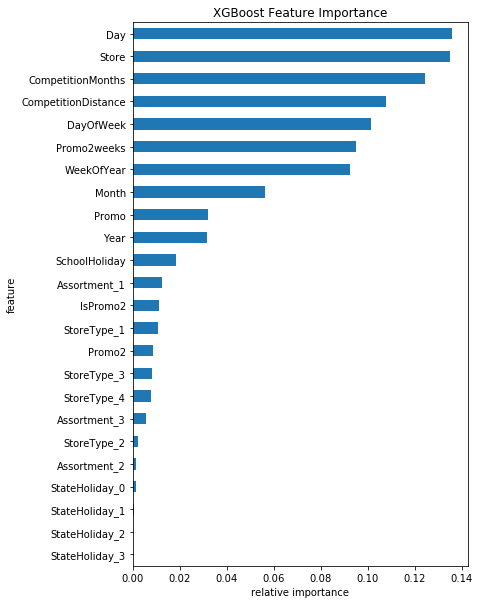

In [70]:
create_feature_map(train_data.columns)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)
plt.show()

相关的思考，有些字段的理解我觉得还是有很多问题。  
1.商店里的商品那么多做Promo2的商品是哪个牌子的哪个型号，难道预测的是笼统销售活动；
2.竞争对手开店时间1900应该是个默认值所以应该不是很准确；  
3.顾客数在预测工作中应该是很重要的，而我在这个模型里却没有想到改如何使用；
